In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import kurtosis

import tensorflow as tf
import tensorflow_hub as hub
from imblearn.over_sampling import SMOTE

In [2]:
deposit_data = pd.read_csv('bank-additional-full.csv', sep=';')
df = deposit_data.copy()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Exploratory Data Analysis

Steps:
* Load data and inspect structure
* Understand data types (numerical, categorical, text, etc.)
* Descriptive statistics (mean, median, std, etc.)
* Visualization (histograms, box plots, scatter plots, etc.)
* Identify relationships between variables (correlation matrix)
* Detect anomalies or patterns (outliers, trends, etc.)

In [5]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(41188, 21)

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# Extract target and predictor variables
target = df['y']
cols = df.columns

# Extract numerical and categorical column names
numerical_cols = df._get_numeric_data().columns
categorical_cols = list(set(cols) - set(numerical_cols))

print(numerical_cols)
print(categorical_cols)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
['housing', 'job', 'day_of_week', 'y', 'month', 'default', 'contact', 'poutcome', 'education', 'loan', 'marital']


#### Numerical Data Analysis

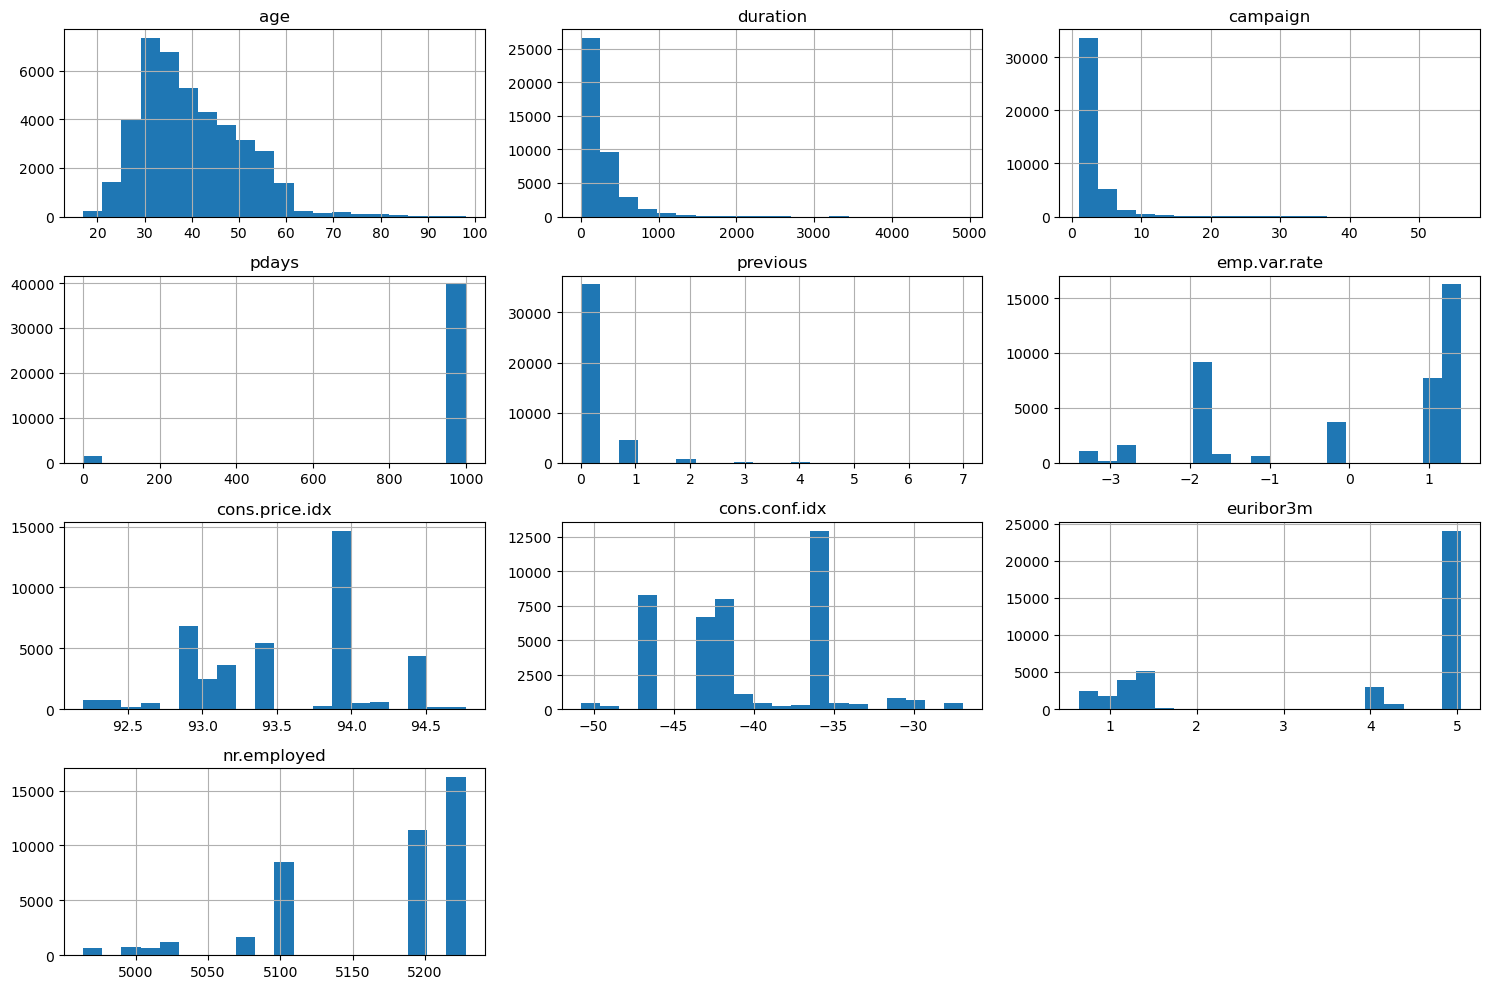

In [9]:
# Plot histograms for numerical columns
df[numerical_cols].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

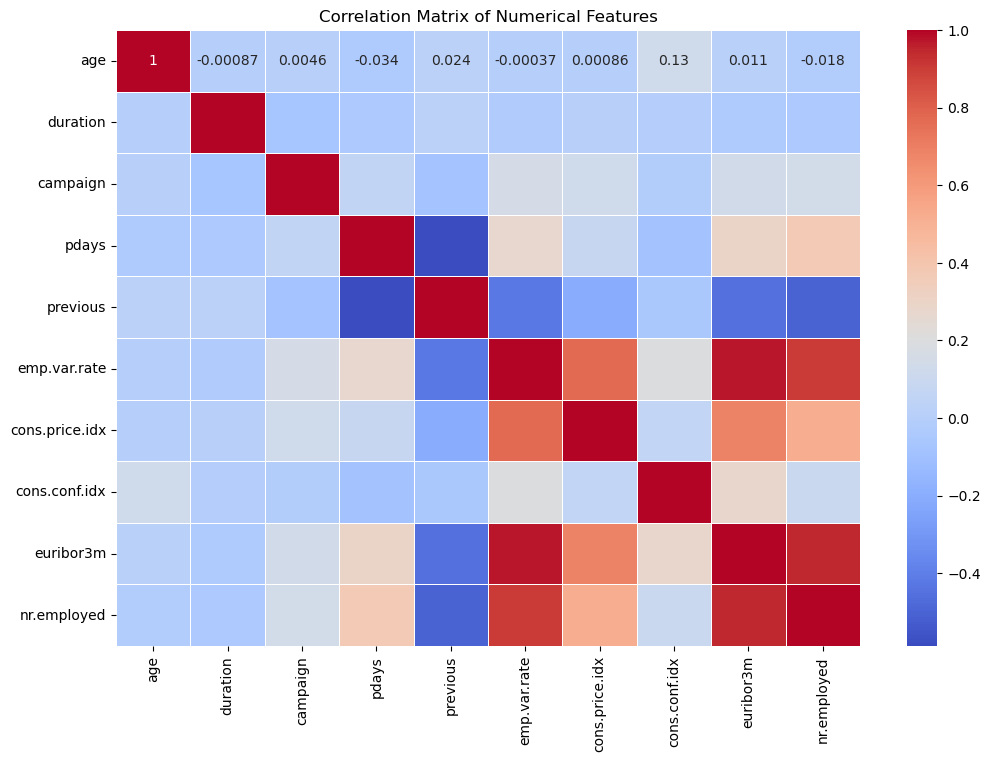

In [10]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

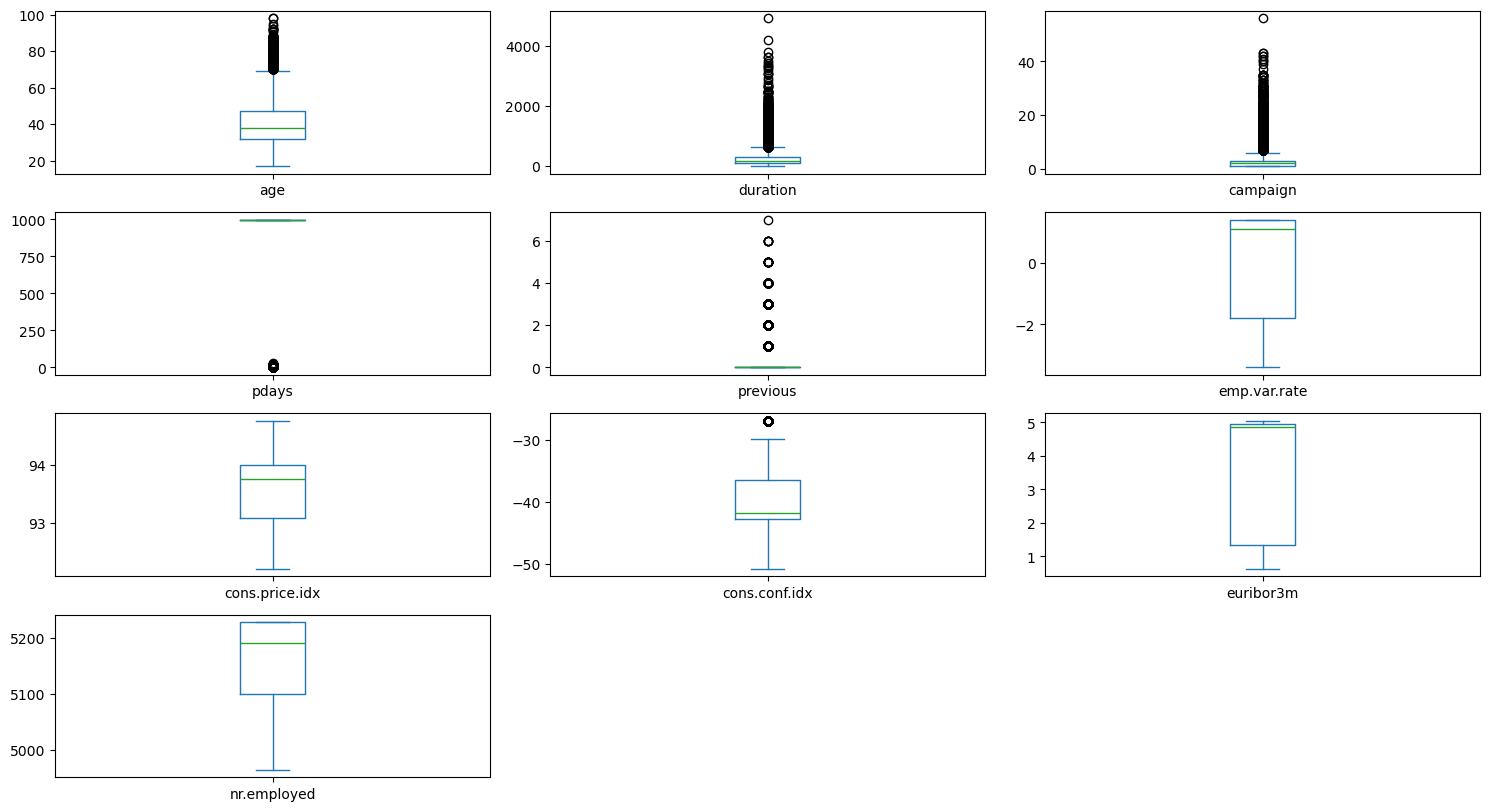

In [11]:
# Plot box plots for numerical columns to detect outliers
df[numerical_cols].plot(kind='box', subplots=True, layout=(5, 3), figsize=(15, 10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

#### Categorical Data Analysis

In [13]:
# Frequency counts for categorical columns
for col in categorical_cols:
    print(f'\nFrequency count for {col}:\n', 
          df.groupby([col, 'y']).size().unstack(fill_value=0))
    
# plt.figure(figsize=(10, 15))
# sns.countplot(data=df, x=col)
# plt.title(f'Count Plot of {col}.')
# plt.xticks(rotation=45)
# plt.show()


Frequency count for housing:
 y           no   yes
housing             
no       16596  2026
unknown    883   107
yes      19069  2507

Frequency count for job:
 y                no   yes
job                      
admin.         9070  1352
blue-collar    8616   638
entrepreneur   1332   124
housemaid       954   106
management     2596   328
retired        1286   434
self-employed  1272   149
services       3646   323
student         600   275
technician     6013   730
unemployed      870   144
unknown         293    37

Frequency count for day_of_week:
 y              no   yes
day_of_week            
fri          6981   846
mon          7667   847
thu          7578  1045
tue          7137   953
wed          7185   949

Frequency count for y:
 y       no   yes
y               
no   36548     0
yes      0  4640

Frequency count for month:
 y         no  yes
month            
apr     2093  539
aug     5523  655
dec       93   89
jul     6525  649
jun     4759  559
mar      270  276
may 

In [14]:
len(categorical_cols)

11

## Data Processing

Steps:
* Handle missing values (imputation, removal)
* Feature engineering (create new features from existing ones)
* Encode categorical variables (one-hot encoding, label encoding)
* Correlation Analysis and Feature Selection
* Normalize/scale numerical features
* Handle imbalanced data (resampling, sythetic data generation)
* Split the data into training, validation and testing sets.

#### Process Categorical Data

In [18]:
# Remove target variable from df
df.drop(columns='y', inplace=True)

# Feature Hashing for Jobs
hasher = FeatureHasher(n_features=15, input_type='string')
hashed_features = hasher.transform(df['job'].apply(lambda x: [x]).tolist())
hashed_df = pd.DataFrame(hashed_features.toarray(), columns=[f'job_hash_{i}' for i in range(15)])
df = pd.concat([df.reset_index(drop=True), hashed_df.reset_index(drop=True)], axis=1)
df.drop(columns='job', inplace=True)

# Ordinal Encoding for Education
education_order = ['illiterate', 'unknown', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df['education_encoded'] = ordinal_encoder.fit_transform(df[['education']])
df.drop(columns='education', inplace=True)

# Combine 'divorced' and 'unknown' with 'single' and one-hot encode marital
df['marital'] = df['marital'].replace({'divorced': 'single', 'unknown': 'single'})
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
marital_encoded = onehot_encoder.fit_transform(df[['marital']])
marital_encoded_df = pd.DataFrame(marital_encoded, columns=onehot_encoder.get_feature_names_out(['marital']))
df = pd.concat([df.reset_index(drop=True), marital_encoded_df.reset_index(drop=True)], axis=1)
df.drop(columns='marital', inplace=True)

# Combine 'unknown' with 'no' for default, housing, and loan
columns_to_replace = ['default', 'housing', 'loan']
df[columns_to_replace] = df[columns_to_replace].replace('unknown', 'no')

# One-hot encode all specified columns
columns_to_encode = columns_to_replace + ['contact', 'month', 'day_of_week', 'poutcome']
encoded_dfs = []
for column in columns_to_encode:
    encoded = onehot_encoder.fit_transform(df[[column]])
    encoded_df = pd.DataFrame(encoded, columns=onehot_encoder.get_feature_names_out([column]))
    encoded_dfs.append(encoded_df)

# Combine encoded columns with original dataframe
df = pd.concat([df.reset_index(drop=True)] + encoded_dfs, axis=1)
df.drop(columns=columns_to_encode, inplace=True)

# Show the first few rows of the preprocessed dataframe
print(df.head())

   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  ...  month_may  month_nov  \
0          -36.4      4.857       5191.0  ...        1.0        0.0   
1          -36.4      4.857       5191.0  ...        1.0        0.0   
2          -36.4      4.857       5191.0  ...        1.0        0.0   
3          -36.4      4.857       5191.0  ...        1.0        0.0   
4          -36.4      4.857       5191.0  ...        1.0        0.0   

   month_oct  month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0        0.0        0.0         

C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

#### Process highly correlated pairs

Highly Correlated Pairs (Correlation > 0.85):
('euribor3m', 'emp.var.rate')
('nr.employed', 'emp.var.rate')
('nr.employed', 'euribor3m')

Features to Drop:
{'emp.var.rate', 'euribor3m'}


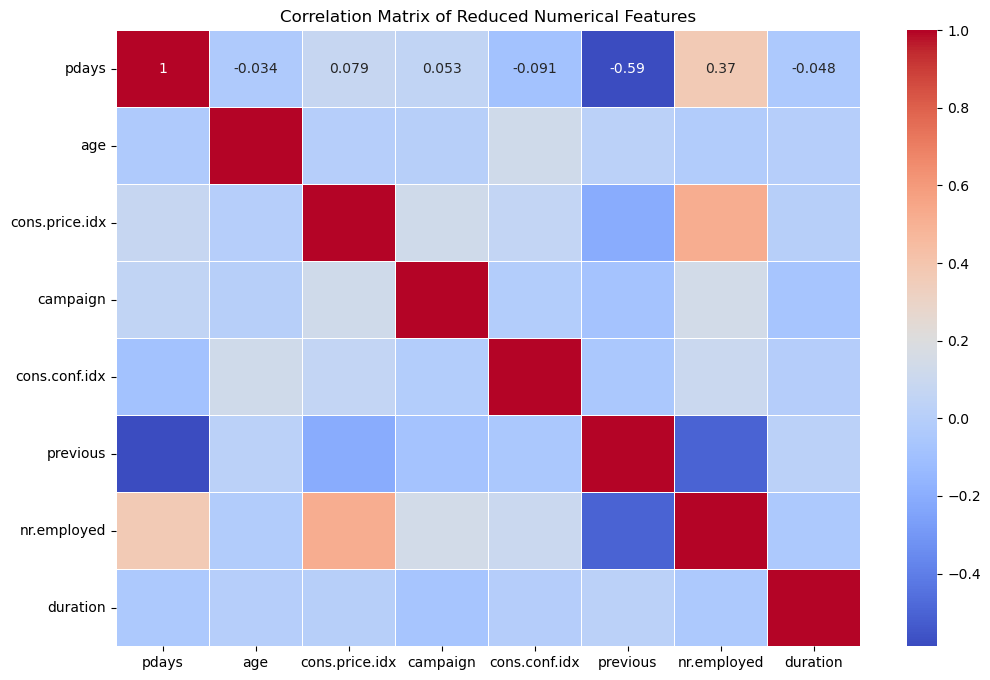

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Set the threshold for high correlation
threshold = 0.85

# Find pairs with correlation coefficients greater than the threshold
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print("Highly Correlated Pairs (Correlation > 0.85):")
for pair in high_corr_pairs:
    print(pair)

# Identify features to drop (keeping one feature from each highly correlated pair)
features_to_drop = set()
for pair in high_corr_pairs:
    features_to_drop.add(pair[1])

print("\nFeatures to Drop:")
print(features_to_drop)

# Drop the identified features from the dataset
df_reduced = df.drop(columns=list(features_to_drop))

numerical_cols_reduced = list(set(numerical_cols) - features_to_drop)

# Display the correlation matrix of the reduced dataset
plt.figure(figsize=(12, 8))
reduced_correlation_matrix = df_reduced[numerical_cols_reduced].corr()
sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title("Correlation Matrix of Reduced Numerical Features")
plt.show()


#### Standardize Numerical Features

In [22]:
# Process 'pdays' numerical feature
df['was_contacted'] = df['pdays'].apply(lambda x: 0 if x==999 else 1)
df['pdays'] = df['pdays'].replace(999, -1)

# Split dataset for benchmarking and realistic model training
X_benchmark = df.copy()
X_realistic = df.drop(columns='duration')

# Identify numerical columns
numerical_cols_benchmark = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
numerical_cols_realistic = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Standardize numerical columns
scaler = StandardScaler()
X_benchmark[numerical_cols_benchmark] = scaler.fit_transform(X_benchmark[numerical_cols_benchmark])
X_realistic[numerical_cols_realistic] = scaler.fit_transform(X_realistic[numerical_cols_realistic])

C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [23]:
X_realistic.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_hash_0,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,was_contacted
0,1.533034,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,1.628993,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.290186,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.002309,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4,1.533034,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


#### Normalize Numerical Features

##### Decision Criteria
* Log Transformation: Apply if skewness is high (e.g > 1 or < -1) and kurtosis is high (e.g > 3)
* MinMax Normalization: Apply if skewness and kurtosis are moderate or if the feature needs to be scaled to a specific range (e.g [0, 1])

In [26]:
# Check feature skewness and kurtosis
skewness = X_realistic[numerical_cols_realistic].skew()
kurt = X_realistic[numerical_cols_realistic].apply(kurtosis)

log_transform_cols = []

# Decision based on skewness and kurtosis
for col in numerical_cols_realistic:
    if abs(skewness[col]) > 1 or kurt[col] > 3:
        log_transform_cols.append(col)

# Apply log transformation
for col in log_transform_cols:
    X_realistic[col] = np.log1p(X_realistic[col])

# Apply MinMax Normalization to all numerical columns (including log-transform)
minmax_scaler = MinMaxScaler()
X_realistic[numerical_cols_realistic] = minmax_scaler.fit_transform(X_realistic[numerical_cols_realistic])

C:\Users\naafi\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site

In [27]:
X_realistic.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_hash_0,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,was_contacted
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,36224.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.284248,0.152001,0.020954,0.067504,0.725393,0.535723,0.430854,0.677237,0.735776,0.070992,...,0.099568,0.017432,0.013839,0.206711,0.209357,0.196416,0.197485,0.863431,0.033335,0.036783
std,0.128657,0.165199,0.110257,0.173169,0.327283,0.225581,0.193648,0.393210,0.410350,0.256814,...,0.299427,0.130877,0.116824,0.404951,0.406855,0.397292,0.398106,0.343396,0.179512,0.188230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185185,0.000000,0.000000,0.000000,0.333333,0.340608,0.338912,0.160961,0.904937,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.259259,0.157422,0.000000,0.000000,0.937500,0.603274,0.376569,0.957379,0.919128,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.370370,0.254792,0.000000,0.000000,1.000000,0.698753,0.602510,0.980957,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
X_realistic.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_hash_0', 'job_hash_1', 'job_hash_2', 'job_hash_3', 'job_hash_4',
       'job_hash_5', 'job_hash_6', 'job_hash_7', 'job_hash_8', 'job_hash_9',
       'job_hash_10', 'job_hash_11', 'job_hash_12', 'job_hash_13',
       'job_hash_14', 'education_encoded', 'marital_single', 'default_yes',
       'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'was_contacted'],
      dtype='object')